In [6]:
'''install required libraries'''
!pip install insightface
!pip install mxnet
!pip install scikit-learn
!pip install opencv-python
!pip install numpy onnxruntime torch torchvision Pillow
!pip install tqdm



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.5/439.5 kB 11.6 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 82.0 MB/s eta 0:00:00
  Created wheel for insightface: filename=insightface-0.7.3-cp310-cp310-linux_x86_64.whl size=1055395 sha256=e0f748257af9500a8ad0067e63d2fbd342ffaa6c8e1c0acd35f7419041fda0d1
  Stored in directory: /root/.cache/pip/wheels/e3/d0/80/e3773fb8b6d1cca87ea1d33d9b1f20a223a6493c896da249b5
Successfully built insightface
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 13.2 MB/s eta 0:00:00
  Attempting uninstall: graphviz
    Found existing installation: graphviz 0.20.3
    Uninstalling graphviz-0.20.3:
      Successfully uninstalled graphviz-0.20.3
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.3/13.3 MB 105.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.0/46.0 kB 4.0 MB/s eta

In [7]:
'''import required libraries'''
import os
import cv2
import numpy as np
import kagglehub
import os
import shutil
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity
from tqdm import tqdm  # Import tqdm for progress bar

/usr/local/lib/python3.10/dist-packages/albumentations/__init__.py:24: UserWarning: A new version of Albumentations is available: 1.4.21 (you have 1.4.20). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [14]:
'''initialize facearc model'''
# Initialize the face analysis app (ArcFace model)
app = FaceAnalysis()
app.prepare(ctx_id=0, det_size=(640, 640))  # Use GPU (ctx_id=0), use CPU with ctx_id=-1


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


In [16]:
'''Load the data set'''
kagglehub.login()
football_players_path = kagglehub.dataset_download('stevish/players')
target_path = '/content/players'
shutil.move(football_players_path, target_path)

100%|██████████| 13.0M/13.0M [00:00<00:00, 62.4MB/s]

Extracting files...


'/content/players'

In [17]:
'''Extract face embedding from dataset'''
# Function to extract embeddings from images in a folder with a progress bar
def extract_embeddings(image_folder):
    embeddings = []  # Store the embeddings
    labels = []      # Store the labels (person names)

    # Loop through each folder (person) in the image folder
    for label in os.listdir(image_folder):
        person_folder = os.path.join(image_folder, label)

        if os.path.isdir(person_folder):  # Make sure it's a directory (not a file)
            # List all images for this person (folder)
            image_files = os.listdir(person_folder)

            # Initialize tqdm progress bar with the total number of images for this person
            for image_file in tqdm(image_files, desc=f"Processing {label}", unit="image"):
                image_path = os.path.join(person_folder, image_file)

                # Read and process each image
                img = cv2.imread(image_path)
                faces = app.get(img)  # Detect faces in the image

                # Extract the embedding for each detected face
                for face in faces:
                    embeddings.append(face.embedding)  # Append the embedding
                    labels.append(label)               # Append the label (person's name)

    return embeddings, labels

# Replace 'path_to_train_folder' with the path to your training dataset
train_image_folder = '/content/players/Footballers_images/Train_set'
train_embeddings, train_labels = extract_embeddings(train_image_folder)

print(f"Extracted embeddings for {len(train_embeddings)} images.")


Processing Messi:   0%|          | 0/75 [00:00<?, ?image/s]/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4
Processing Suarez: 100%|██████████| 75/75 [00:58<00:00,  1.28image/s]

Extracted embeddings for 425 images.


In [21]:
app = FaceAnalysis()
app.prepare(ctx_id=0, det_size=(640, 640))  # Use GPU (ctx_id=0), use CPU with ctx_id=-1
import pickle # Import the pickle module

def save_embeddings(embeddings, labels, embeddings_file='train_embeddings.pkl', labels_file='train_labels.pkl'):
    with open(embeddings_file, 'wb') as emb_file:
        pickle.dump(embeddings, emb_file) # Use pickle.dump to save the embeddings
    with open(labels_file, 'wb') as lbl_file:
        pickle.dump(labels, lbl_file) # Use pickle.dump to save the labels

    print(f"Embeddings and labels saved to {embeddings_file} and {labels_file}")

# Example usage after extracting embeddings from your training set
save_embeddings(train_embeddings, train_labels) # Call the function to save the embeddings and labels

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)
Embeddings a

/usr/local/lib/python3.10/dist-packages/onnxruntime/capi/onnxruntime_inference_collection.py:115: UserWarning: Specified provider 'CUDAExecutionProvider' is not in available provider names.Available providers: 'AzureExecutionProvider, CPUExecutionProvider'
  warnings.warn(


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: /root/.insightface/models/buffalo_l/w600k_r50.onnx recognition ['None', 3, 112, 112] 127.5 127.5
set det-size: (640, 640)


Saving 203ab970-8d34-11ef-bee0-39b1bce7fdf1.jpg to 203ab970-8d34-11ef-bee0-39b1bce7fdf1 (1).jpg
Processing 203ab970-8d34-11ef-bee0-39b1bce7fdf1 (1).jpg...


/usr/local/lib/python3.10/dist-packages/insightface/utils/transform.py:68: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  P = np.linalg.lstsq(X_homo, Y)[0].T # Affine matrix. 3 x 4


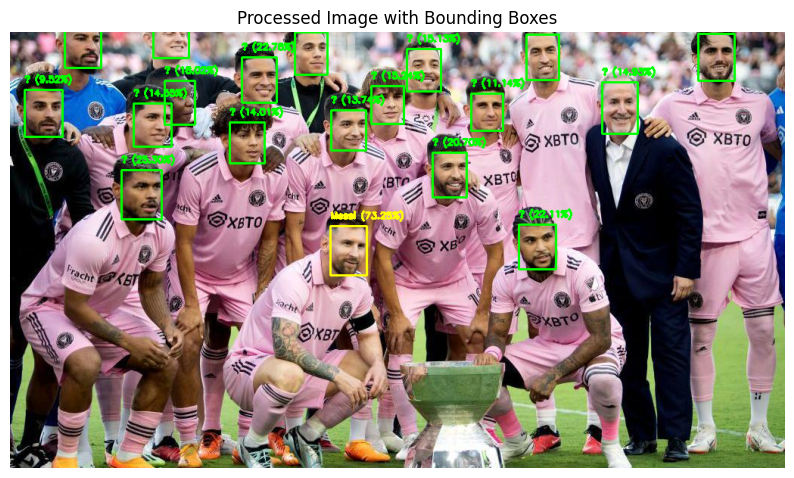

Results:
🎯 Detected Players: Messi
❓ Unknown Players Detected: 18
❌ Absent Players: Neymar, iniesta, Xavi, Suarez


In [56]:
import cv2
import pickle
import numpy as np
from google.colab import files
from matplotlib import pyplot as plt
from insightface.app import FaceAnalysis
from sklearn.metrics.pairwise import cosine_similarity

# File paths
EMBEDDINGS_PATH = "/content/train_embeddings.pkl"
LABELS_PATH = "/content/train_labels.pkl"

# Load saved embeddings and labels
with open(EMBEDDINGS_PATH, "rb") as f:
    saved_embeddings = pickle.load(f)
with open(LABELS_PATH, "rb") as f:
    saved_labels = pickle.load(f)

# Initialize ArcFace model
app = FaceAnalysis()
app.prepare(ctx_id=0, det_size=(640, 640))  # Use GPU (ctx_id=0), or set ctx_id=-1 for CPU

# Embedding extraction function
def extract_embeddings(image):
    faces = app.get(image)  # Detect faces in the image
    embeddings = []
    if faces:
        for face in faces:
            embeddings.append(face.embedding)  # Extract embedding for each detected face
    return embeddings, faces

# Function to process the image and add bounding boxes
def process_image(image_path):
    # Load the image
    image = cv2.imread(image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Extract embeddings and faces
    embeddings, faces = extract_embeddings(image_rgb)
    if not embeddings:
        print("❌ No face detected in the image.")
        return image_rgb, None

    detected_labels = []
    absent_labels = set(saved_labels)
    unknown_count = 0

    # Draw bounding boxes and display confidence scores
    for embedding, face in zip(embeddings, faces):
        similarities = cosine_similarity([embedding], saved_embeddings)
        most_similar_index = np.argmax(similarities)
        similarity_score = similarities[0][most_similar_index]

        # Determine label and confidence
        if similarity_score >= 0.5:  # Threshold for known players
            predicted_label = saved_labels[most_similar_index]
            detected_labels.append(predicted_label)
            absent_labels.discard(predicted_label)
            label = f"{predicted_label} ({similarity_score * 100:.2f}%)"
            label_color = (255, 255, 0)  # Yellow for detected players
            box_color = (255, 255, 0)   # Yellow bounding box for detected players
        else:
            unknown_count += 1
            # Fun label for unknown faces with confidence level
            label = f"? ({similarity_score * 100:.2f}%)"
            label_color = (0, 255, 0)  # Green for unknown players
            box_color = (0, 255, 0)   # Green bounding box for unknown players

        # Draw bounding box
        bbox = face.bbox.astype(int)
        cv2.rectangle(image_rgb, (bbox[0], bbox[1]), (bbox[2], bbox[3]), box_color, 2)

        # Place the label on a single line
        text_y = bbox[1] - 10  # Adjust position slightly above the bounding box
        cv2.putText(
            image_rgb,
            label,
            (bbox[0], text_y),  # Position horizontally aligned with the box
            cv2.FONT_HERSHEY_SIMPLEX,
            0.4,  # Font size for readability
            label_color,
            2  # Text thickness
        )

    # Prepare result summary
    detected_str = ', '.join(detected_labels) if detected_labels else "None"
    absent_str = ', '.join(absent_labels) if absent_labels else "None"

    result_text = (
        f"🎯 Detected Players: {detected_str}\n"
        f"❓ Unknown Players Detected: {unknown_count}\n"
        f"❌ Absent Players: {absent_str}"
    )
    return image_rgb, result_text

# Upload an image and process it
uploaded = files.upload()
for filename in uploaded.keys():
    print(f"Processing {filename}...")

    # Process the uploaded image
    processed_image, result_text = process_image(filename)

    # Display the processed image with bounding boxes
    plt.figure(figsize=(10, 10))
    plt.imshow(processed_image)
    plt.axis("off")
    plt.title("Processed Image with Bounding Boxes")
    plt.show()

    # Display the results
    if result_text:
        print(f"Results:\n{result_text}")


# New Section